In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, SpatialDropout2D, Permute
from tensorflow.keras.callbacks import ModelCheckpoint

d:\pYthon_Directory\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\pYthon_Directory\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization,
    Activation, AveragePooling2D, Dropout, Flatten, Dense, Multiply,
    Conv1D, GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf


class EEGNetWithAttentionConv1D(Model):
    def __init__(self, nb_classes, Chans=64, Samples=128, dropoutRate=0.3,
                 kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25):
        super(EEGNetWithAttentionConv1D, self).__init__()

        # Temporal Conv Layer
        self.conv1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()

        # Depthwise Spatial Conv Layer
        self.depthwise = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                                         depthwise_constraint=max_norm(1.))
        self.bn2 = BatchNormalization()
        self.act1 = Activation('elu')
        self.pool1 = AveragePooling2D((1, 4))
        self.drop1 = Dropout(dropoutRate)

        # Separable Conv Layer
        self.sepconv = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')
        self.bn3 = BatchNormalization()
        self.act2 = Activation('elu')
        self.pool2 = AveragePooling2D((1, 8))
        self.drop2 = Dropout(dropoutRate)

        # Attention (with regularization)
        self.attention_conv = Conv2D(1, (1, 1), activation='sigmoid', padding='same',
                                     kernel_regularizer=l2(1e-4))

        # Temporal Conv Block
        self.reshape_for_conv1d = Reshape((-1, F2))  # (batch, time_steps, features)
        self.conv1d = Conv1D(64, kernel_size=3, padding='same', activation='relu')
        self.bn4 = BatchNormalization()
        self.global_pool = GlobalAveragePooling1D()

        # Final classifier
        self.classifier = Dense(nb_classes, activation='softmax',
                                kernel_constraint=max_norm(norm_rate), name='softmax')

    def spatial_attention_module(self, x):
        attention = tf.reduce_mean(x, axis=-1, keepdims=True)  # Mean over filters
        attention = self.attention_conv(attention)              # Apply conv to attention map
        return Multiply()([x, attention])                       # Apply attention

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        conv1_out = self.bn1(x)
        x = self.bn1(x, training=training)

        x = self.depthwise(x)
        depthwise_out = self.bn2(x, training=training)
        #x = self.bn2(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.sepconv(x)
        x = self.bn3(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)
        mean_feature_map = tf.reduce_mean(x, axis=-1, keepdims=True)  # shape: (batch, chans, time, 1)
        attention_map = self.attention_conv(mean_feature_map) 

        # Apply spatial attention
        x = self.spatial_attention_module(x)

        # Temporal Conv1D block
        x = self.reshape_for_conv1d(x)
        x = self.conv1d(x)
        x = self.bn4(x, training=training)
        x = self.global_pool(x)

        # Classifier
        return self.classifier(x), conv1_out,attention_map, depthwise_out



In [3]:
model = EEGNetWithAttentionConv1D(nb_classes=2, Chans=14, Samples=128)
model.build(input_shape=(None, 14, 128, 1))
model.summary()

Model: "eeg_net_with_attention_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  512       
                                                                 
 batch_normalization (BatchN  multiple                 32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  multiple                 224       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                     

In [4]:
# load EEG Data
eeg=np.load('D:/lab_work_25/july/NEW WORK/mental_Data/processed_data/segments_shuffled.npy')
label=np.load('D:/lab_work_25/july/NEW WORK/mental_Data/processed_data/segment_labels_shuffled.npy')
print(eeg.shape,label.shape)
label_cat = to_categorical(label, num_classes=2)
print(label_cat.shape)  # Should be (12201, 3) after one-hot encoding

(13455, 128, 14) (13455,)
(13455, 2)


In [5]:
label_cat[405:510]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [6]:
eeg=np.swapaxes(eeg, 1, 2)  # Change shape from (12201, 128, 64) to (12201, 64, 128)
print(eeg.shape,label_cat.shape)
eeg=np.expand_dims(eeg, axis=-1)  # Add a channel dimension, shape becomes (12201, 64, 128, 1)
print(eeg.shape,label_cat.shape)

(13455, 14, 128) (13455, 2)
(13455, 14, 128, 1) (13455, 2)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(eeg, label_cat, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)  # Should be (6000, 1024, 1) and (6000, 3)
print(X_test.shape, y_test.shape)  # Should be (6000, 1024, 1) and (6000, 3)

(10764, 14, 128, 1) (10764, 2)
(2691, 14, 128, 1) (2691, 2)


In [8]:
nb_classes = 2
Chans = 14
Samples = 128
num_samples = 10764

In [9]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "eeg_net_with_attention_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  512       
                                                                 
 batch_normalization (BatchN  multiple                 32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  multiple                 224       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  multiple                 64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                     

In [10]:
model.load_weights('D:/lab_work_25/july/NEW WORK/mental_Data/model_weight/EEGNET_TCN2/best_model_weights.h5')


In [11]:
preds, conv1_activations, attention_map, depthwise_out = model(X_test)


In [12]:
import numpy as np

# Convert to numpy
conv1_acts = conv1_activations.numpy()  # Shape: (samples, 1, time, filters)

conv1_acts.shape

(2691, 14, 128, 8)

In [13]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [14]:
class_labels = np.argmax(y_test, axis=1)  # shape: (2691,)

# Step 2: Get indices for each class
low_idx = np.where(class_labels == 0)[0]   # class 0: low workload
high_idx = np.where(class_labels == 1)[0]  # class 1: high workload

# Step 3: Separate activations
low_acts = conv1_acts[low_idx]     # shape: (num_low, 14, 128, 8)
high_acts = conv1_acts[high_idx]   # shape: (num_high, 14, 128, 8)

In [15]:
low_acts.shape, high_acts.shape

((1182, 14, 128, 8), (1509, 14, 128, 8))

In [16]:
# Average over channels and time (axes 1 and 2)
low_mean_per_filter = np.mean(low_acts, axis=(1, 2))     # shape: (1182, 8)
high_mean_per_filter = np.mean(high_acts, axis=(1, 2))   # e.g., (1509, 8) if you have 1509 high trials

# Now compute the mean activation per filter (final average across trials)
low_mean_filters = np.mean(low_mean_per_filter, axis=0)   # shape: (8,)
high_mean_filters = np.mean(high_mean_per_filter, axis=0) # shape: (8,)


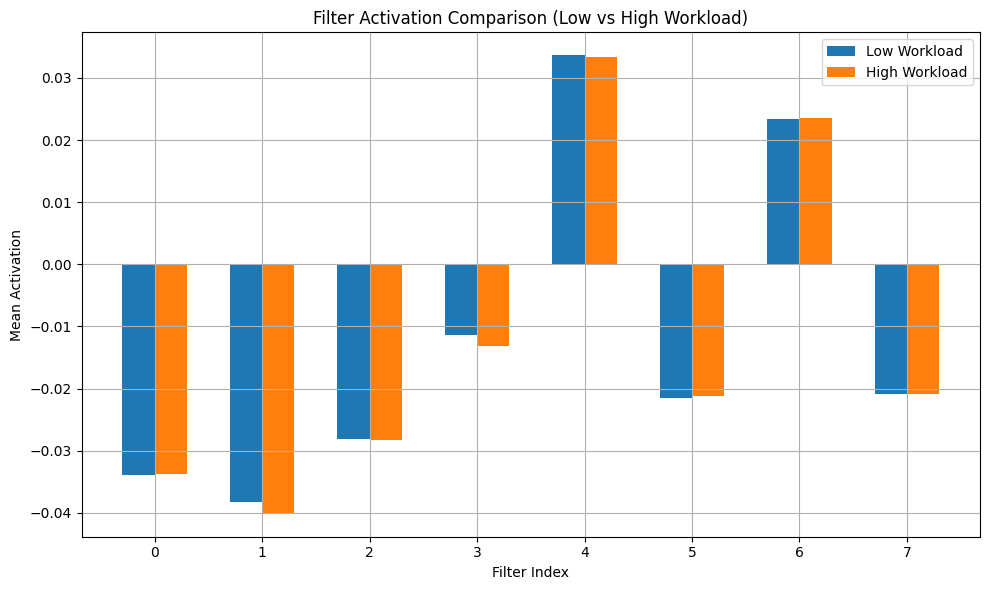

In [17]:
import matplotlib.pyplot as plt
import numpy as np

filters = np.arange(8)

plt.figure(figsize=(10, 6))
plt.bar(filters - 0.15, low_mean_filters, width=0.3, label='Low Workload')
plt.bar(filters + 0.15, high_mean_filters, width=0.3, label='High Workload')
plt.xlabel('Filter Index')
plt.ylabel('Mean Activation')
plt.title('Filter Activation Comparison (Low vs High Workload)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
'''test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')'''

"test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)\nprint(f'Test accuracy: {test_acc:.4f}')\nprint(f'Test loss: {test_loss:.4f}')"

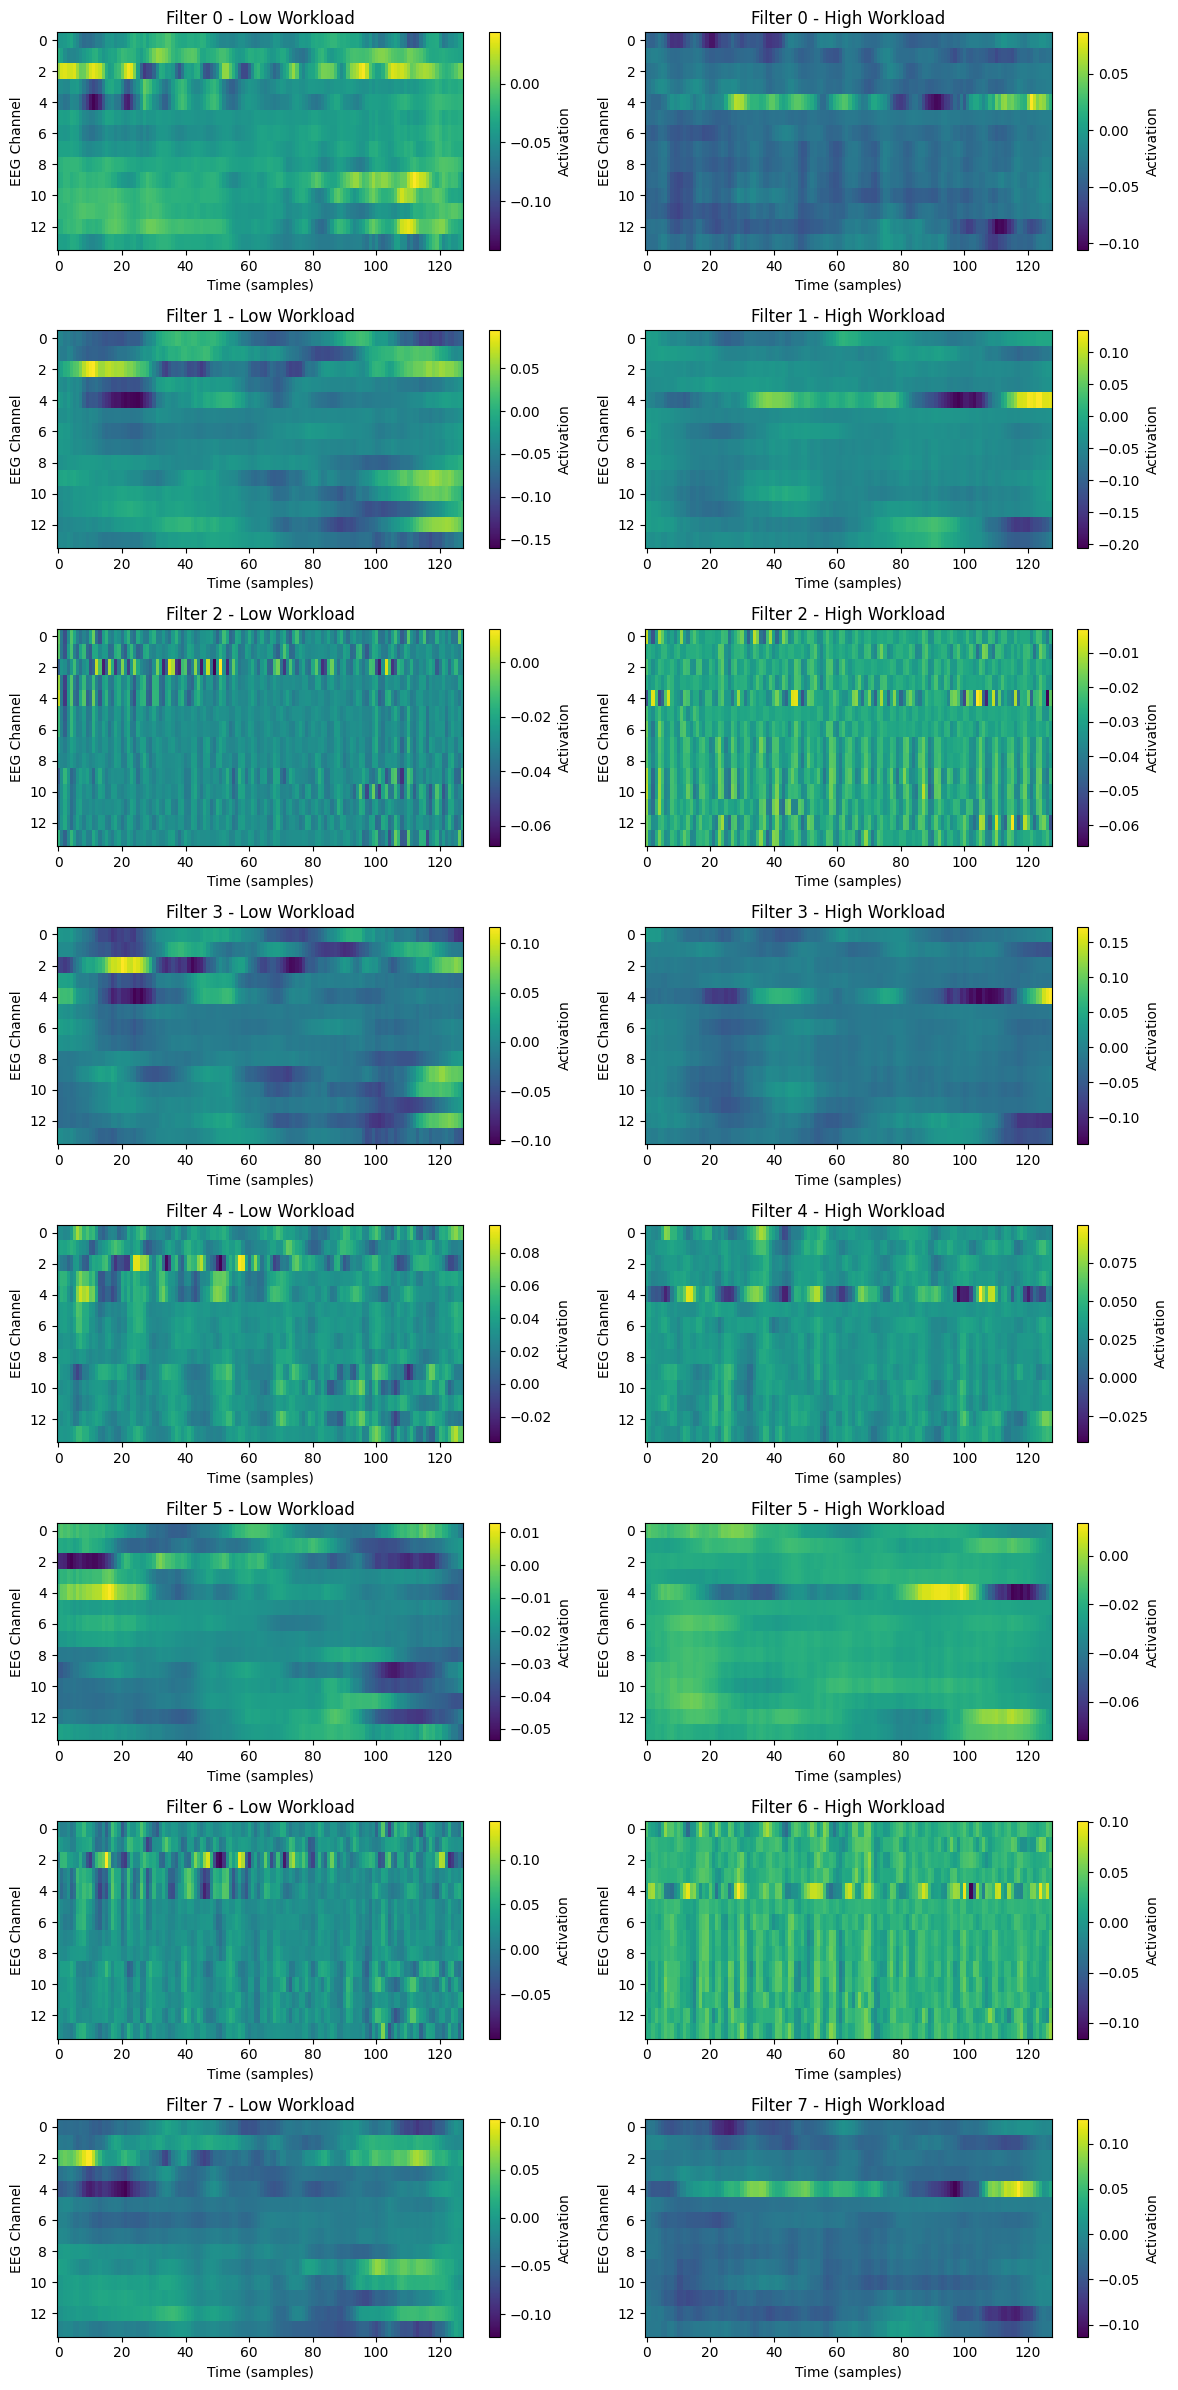

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assume low_acts and high_acts have shape (n_samples, 14, 128, 8)
n_filters = low_acts.shape[-1]

# Create figure with subplots: 8 rows × 2 columns
fig, axs = plt.subplots(n_filters, 2, figsize=(12, 3 * n_filters))

for filter_index in range(n_filters):
    # Compute mean activations for the current filter
    mean_low = np.mean(low_acts[..., filter_index], axis=0)   # shape: (14, 128)
    mean_high = np.mean(high_acts[..., filter_index], axis=0) # shape: (14, 128)

    # Plot for low workload
    ax_low = axs[filter_index, 0]
    im_low = ax_low.imshow(mean_low, aspect='auto', cmap='viridis')
    ax_low.set_title(f'Filter {filter_index} - Low Workload')
    ax_low.set_xlabel('Time (samples)')
    ax_low.set_ylabel('EEG Channel')
    fig.colorbar(im_low, ax=ax_low, orientation='vertical', label='Activation')

    # Plot for high workload
    ax_high = axs[filter_index, 1]
    im_high = ax_high.imshow(mean_high, aspect='auto', cmap='viridis')
    ax_high.set_title(f'Filter {filter_index} - High Workload')
    ax_high.set_xlabel('Time (samples)')
    ax_high.set_ylabel('EEG Channel')
    fig.colorbar(im_high, ax=ax_high, orientation='vertical', label='Activation')

# Layout adjustment
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def get_mean_per_channel(depth_output, D):
    depth_np = depth_output.numpy()  # Convert to NumPy
    B, H, T, C = depth_np.shape
    C_per_channel = C // D
    depth_np = depth_np.reshape(B, H, T, C_per_channel, D)
    mean_activation = np.mean(depth_np, axis=(0, 1, 2, 4))  # Mean over batch, time, D
    return mean_activation


In [ ]:
class_labels = np.argmax(y_test, axis=1) 

In [ ]:
X_low = X_test[class_labels == 0]      # All low workload EEG
X_high = X_test[class_labels == 1]     # All high workload EEG


In [ ]:
X_low[1:3,].shape

(2, 14, 128, 1)

In [ ]:
X_low.shape

(1182, 14, 128, 1)